In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from pptoolbox.platform.preprocessing import preprocess_v2
from pptoolbox.preprocessing import SNV, MSC, SavitzkyGolay, Detrend
from pptoolbox.visualization import (plot_spectra, plot_loadings, plot_scree, fit_pca,
                                               generate_pc_df, plot_svp, initialize_theme, spectral_vector_properties)


from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

from pathlib import Path

# import

In [55]:
pulldate = "250620"

datafolder_path = Path ("../data/")
raw_csv = datafolder_path / f"raw/spectra_{pulldate}.csv"
spectra_df = pd.read_csv(raw_csv)

spectra_df.shape

(50, 35)

In [56]:
spectra_df['lot_id'].nunique()

10

In [57]:
spectra_df.columns

Index(['lot_id', 'active', 'analyzer_id', 'raw_data_mini', 'raw_data_neo',
       'company_id', 'dark_ref_data_mini', 'dark_ref_data_neo',
       'dark_ref_scan_time', 'date_scanned', 'detector_temp', 'frame_data',
       'healthy', 'id', 'integration_time', 'integration_time_neo', 'name',
       'scope_data_mini', 'scope_data_neo', 'spectrometer_temp_mini',
       'spectrometer_temp_neo', 'user_id', 'version', 'white_ref_data_mini',
       'white_ref_data_neo', 'white_ref_scan_time', 'raw_data',
       'dark_ref_data', 'white_ref_data', 'scope_data', 'specimen_id',
       'lot_name', 'analyser_id', 'product_id', 'product_name'],
      dtype='object')

In [58]:
spectra_df = spectra_df.rename(columns={'calc_data_mini':'raw_data_mini','calc_data_neo':'raw_data_neo'})
spectra_df['raw_data'] = np.nan

spectra_df_og = spectra_df.copy(deep=True)
spectra_df.head()

,lot_id,active,analyzer_id,raw_data_mini,raw_data_neo,company_id,dark_ref_data_mini,dark_ref_data_neo,dark_ref_scan_time,date_scanned,...,white_ref_scan_time,raw_data,dark_ref_data,white_ref_data,scope_data,specimen_id,lot_name,analyser_id,product_id,product_name
0,102492,1,107,"[{""wavelength"": 291.56201171875, ""reflectance""...","[{""wavelength"": 929.386962890625, ""reflectance...",1330,"[-2.4719483852386475, -0.9356455206871033, 0.8...","[27.814165115356445, 17.62775230407715, 14.698...",1749605810,1749609643,...,1749605825,NaN,NaN,NaN,NaN,605180,P_21_5_5_colEX_D_1of5Rio_1,107,6892,test_powder
1,102492,1,107,"[{""wavelength"": 291.56201171875, ""reflectance""...","[{""wavelength"": 929.386962890625, ""reflectance...",1330,"[-2.4719483852386475, -0.9356455206871033, 0.8...","[27.814165115356445, 17.62775230407715, 14.698...",1749605810,1749609677,...,1749605825,NaN,NaN,NaN,NaN,605182,P_21_5_5_colEX_D_1of5Rio_1,107,6892,test_powder
2,102492,1,107,"[{""wavelength"": 291.56201171875, ""reflectance""...","[{""wavelength"": 929.386962890625, ""reflectance...",1330,"[-2.4719483852386475, -0.9356455206871033, 0.8...","[27.814165115356445, 17.62775230407715, 14.698...",1749605810,1749609709,...,1749605825,NaN,NaN,NaN,NaN,605183,P_21_5_5_colEX_D_1of5Rio_1,107,6892,test_powder
3,102493,1,107,"[{""wavelength"": 291.56201171875, ""reflectance""...","[{""wavelength"": 929.386962890625, ""reflectance...",1330,"[-2.4719483852386475, -0.9356455206871033, 0.8...","[27.814165115356445, 17.62775230407715, 14.698...",1749605810,1749609784,...,1749605825,NaN,NaN,NaN,NaN,605184,P_22_5_5_colEX_D_1of5Rio_2,107,6892,test_powder
4,102493,1,107,"[{""wavelength"": 291.56201171875, ""reflectance""...","[{""wavelength"": 929.386962890625, ""reflectance...",1330,"[-2.4719483852386475, -0.9356455206871033, 0.8...","[27.814165115356445, 17.62775230407715, 14.698...",1749605810,1749609817,...,1749605825,NaN,NaN,NaN,NaN,605185,P_22_5_5_colEX_D_1of5Rio_2,107,6892,test_powder


In [59]:
info_df = spectra_df[['lot_id', 'lot_name']].copy(deep=True)

# info_df['scan_date'] = pd.to_datetime(info_df['date_scanned'], unit='s')
# info_df['scan_date'] = info_df['scan_date'].dt.date

# concentrations = {
#     'A' : 0,
#     'B' : 0.5,
#     'C' : 1,
#     'D' : 1.5,
#     'E' : 2,
#     'F' : 3,
#     'G' : 4,
#     'H' : 5,
# }

# # Extract middle part and map to concentration
# info_df['concentration'] = info_df['lot_name'].str.split('_').str[1].map(concentrations)

info_df = info_df.rename(columns={
    'lot_name':'Lot_Name',
    'date_scanned':'Date_Scanned',
    })

info_df = info_df.drop_duplicates()
info_df

,lot_id,Lot_Name
0,102492,P_21_5_5_colEX_D_1of5Rio_1
3,102493,P_22_5_5_colEX_D_1of5Rio_2
6,102494,P_23_5_5_colEX_D_1of5Rio_3
9,102495,P_24_5_5_colEX_D_1of5Rio_4
12,102496,P_25_5_5_colEX_D_1of5Rio_5
15,102512,P_41_9_9_colEX_D_1of5Rio_1
18,102513,P_42_9_9_colEX_D_1of5Rio_2
21,102514,P_43_9_9_colEX_D_1of5Rio_3
24,102515,P_44_9_9_colEX_D_1of5Rio_4
27,102516,P_45_9_9_colEX_D_1of5Rio_5


# preprocess

In [60]:
X_visnir, X_exnir, y, datatype = preprocess_v2(spectra_df, info_df)

In [61]:
display(X_visnir.head())
display(X_exnir.head())
display(y.head())

,480.0,483.0,486.0,489.0,492.0,495.0,498.0,501.0,504.0,507.0,...,1023.0,1026.0,1029.0,1032.0,1035.0,1038.0,1041.0,1044.0,1047.0,1050.0
lot_id,,,,,,,,,,,,,,,,,,,,,
102492,2.152820,2.194500,2.227186,2.266117,2.289423,2.347298,2.360627,2.398020,2.431409,2.479893,...,29.477760,29.819752,29.886583,30.016917,30.334284,30.439536,30.333569,30.825227,30.946528,31.128929
102492,2.200728,2.236899,2.268502,2.314487,2.345300,2.402588,2.420058,2.472398,2.507437,2.566038,...,31.346300,31.600898,31.781459,31.804605,32.006037,32.343627,32.017566,32.539967,32.530959,32.898101
102492,1.778377,1.794469,1.823754,1.850895,1.875014,1.915193,1.925174,1.960058,1.978444,2.030877,...,25.418699,25.821090,26.020111,26.086114,26.263624,26.422909,26.289910,26.850437,26.966016,27.208107
102492,1.761815,1.776993,1.795871,1.831949,1.849076,1.881139,1.899538,1.934084,1.960438,1.992808,...,25.098608,25.309887,25.427319,25.529046,25.902610,25.927163,26.028878,26.248362,26.364517,26.729328
102492,1.917211,1.957217,1.971467,2.019323,2.039583,2.071059,2.093883,2.132969,2.172425,2.193190,...,27.567947,27.638461,27.807579,27.759704,28.083720,28.132597,28.503305,28.615257,28.794751,28.929367


,975.0,984.0,993.0,1002.0,1011.0,1020.0,1029.0,1038.0,1047.0,1056.0,...,1569.0,1578.0,1587.0,1596.0,1605.0,1614.0,1623.0,1632.0,1641.0,1650.0
lot_id,,,,,,,,,,,,,,,,,,,,,
102492,26.210031,26.525291,26.892095,27.238590,27.643083,28.012977,28.399256,28.771667,29.127247,29.479665,...,21.211979,21.339817,21.550675,21.833511,22.136727,22.363822,22.546724,22.732935,22.908041,23.079195
102492,29.964513,30.284199,30.636397,30.997967,31.396226,31.781116,32.160608,32.532324,32.883254,33.230508,...,24.484842,24.628389,24.856550,25.166328,25.494600,25.746927,25.950743,26.158883,26.359023,26.553331
102492,24.685425,24.970851,25.298197,25.610973,25.966886,26.297658,26.629127,26.957766,27.269860,27.573782,...,20.274762,20.392247,20.575932,20.833504,21.111127,21.313309,21.471595,21.657532,21.817603,21.979787
102492,23.915046,24.202328,24.495991,24.804722,25.138527,25.457055,25.787903,26.089346,26.396039,26.670086,...,19.306057,19.420818,19.598425,19.848200,20.118485,20.327114,20.498873,20.670943,20.843443,20.990130
102492,26.040405,26.327955,26.657893,26.971817,27.337002,27.690476,28.022234,28.355841,28.670516,28.975880,...,21.353366,21.481624,21.671541,21.942848,22.229466,22.448675,22.621573,22.792759,22.973219,23.135409


,Lot_Name
lot_id,
102492,P_21_5_5_colEX_D_1of5Rio_1
102492,P_21_5_5_colEX_D_1of5Rio_1
102492,P_21_5_5_colEX_D_1of5Rio_1
102492,P_21_5_5_colEX_D_1of5Rio_1
102492,P_21_5_5_colEX_D_1of5Rio_1


In [62]:
X_visnir.shape, X_exnir.shape, y.shape

((50, 191), (50, 76), (50, 1))

In [63]:
label_df = pd.merge(y.reset_index().drop_duplicates(), spectra_df[['lot_name','date_scanned']], left_on='Lot_Name', right_on='lot_name', how='left')
label_df = label_df.drop(columns=['lot_name'])
label_df = label_df.set_index('lot_id')
label_df_og = label_df.copy(deep=True)
label_df

,Lot_Name,date_scanned
lot_id,,
102492,P_21_5_5_colEX_D_1of5Rio_1,1749609643
102492,P_21_5_5_colEX_D_1of5Rio_1,1749609677
102492,P_21_5_5_colEX_D_1of5Rio_1,1749609709
102492,P_21_5_5_colEX_D_1of5Rio_1,1749625033
102492,P_21_5_5_colEX_D_1of5Rio_1,1749625068
102493,P_22_5_5_colEX_D_1of5Rio_2,1749609784
102493,P_22_5_5_colEX_D_1of5Rio_2,1749609817
102493,P_22_5_5_colEX_D_1of5Rio_2,1749609850
102493,P_22_5_5_colEX_D_1of5Rio_2,1749625108


In [64]:
label_df = label_df_og.copy(deep=True)

In [65]:
label_df['Date_Scanned'] = pd.to_datetime(label_df['date_scanned'], unit='s')
label_df['Date_Scanned'] = label_df['Date_Scanned'].dt.date
label_df = label_df.drop(columns=['date_scanned', 'Lot_Name'])
label_df.head()

,Date_Scanned
lot_id,
102492,2025-06-11
102492,2025-06-11
102492,2025-06-11
102492,2025-06-11
102492,2025-06-11


In [66]:
label_type_list = ['clf' if label_df[col].dtypes == 'object' else 'reg' for col in label_df.columns]
param_label_map = dict(zip(label_df.columns, label_type_list))
param_label_map

{'Date_Scanned': 'clf'}

In [67]:
spectral_ranges = {
    'visnir':{
        'spectrum': X_visnir
    },
    'exnir':{
        'spectrum': X_exnir
    }
}

# Check for Outliers

In [68]:
label = 'Coffee'

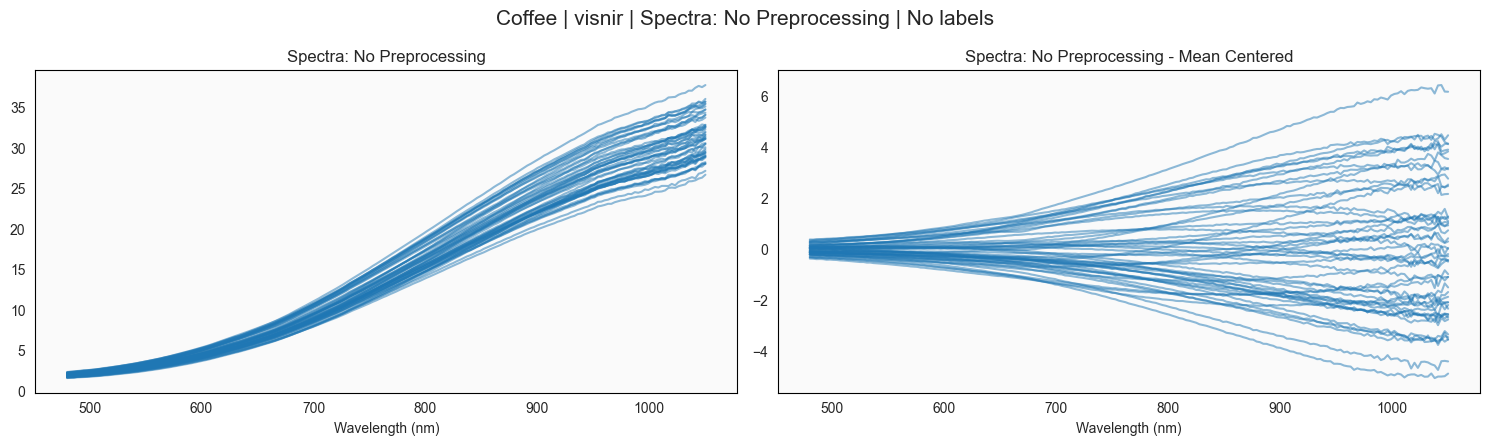

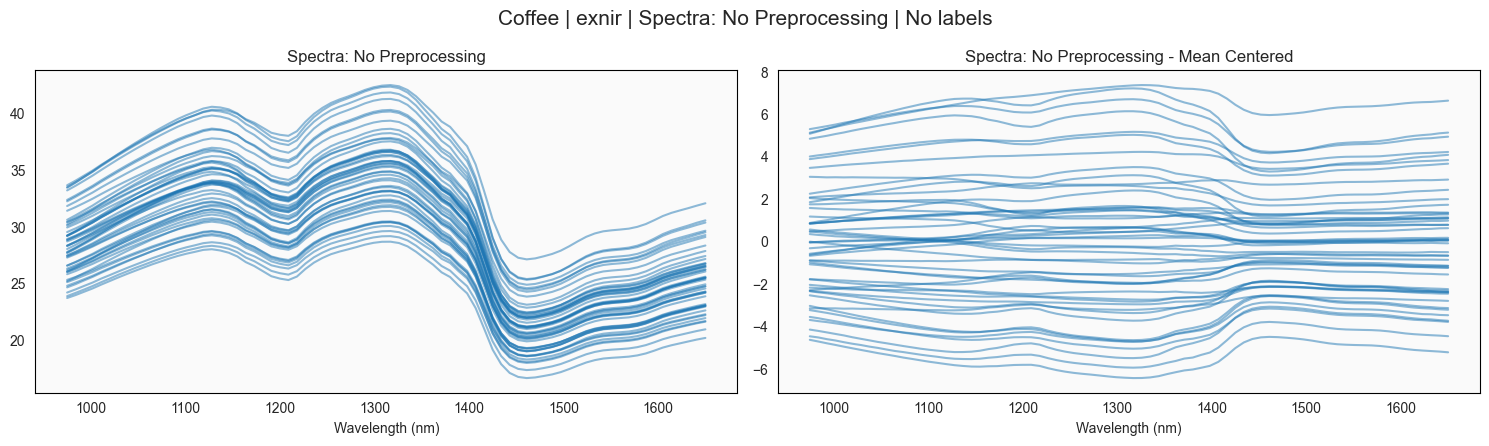

In [69]:
PREPROCESSING = 'No Preprocessing'
SAMPLE_TYPE = f'{label}'
cmap=sns.color_palette()

for spectral_range in spectral_ranges:
    SAMPLE_TYPE = f'{label} | {spectral_range}'
    raw_df = spectral_ranges[spectral_range]['spectrum']

    plot_spectra(raw_df, labels=None,
             spec_prep=PREPROCESSING,
             sample_type=SAMPLE_TYPE,
             cmap=cmap);

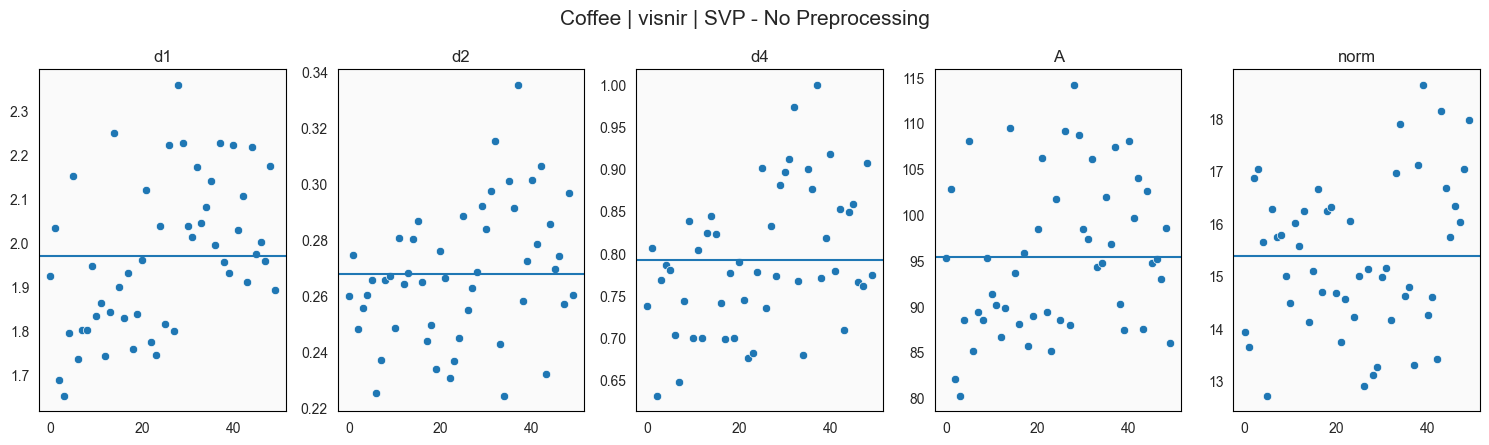

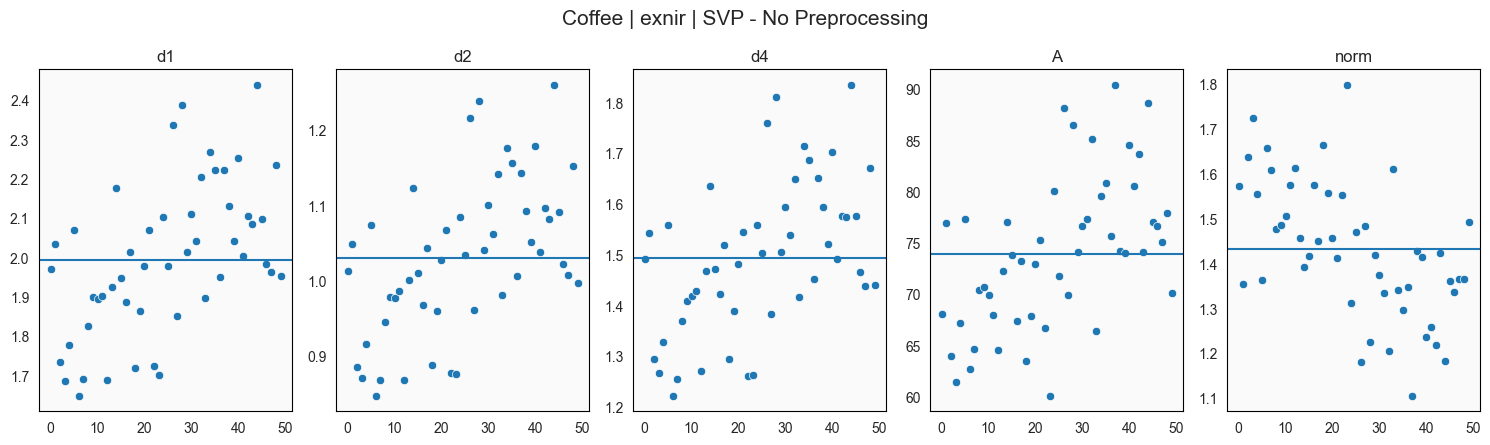

In [70]:
for spectral_range in spectral_ranges:
    SAMPLE_TYPE = f'{label} | {spectral_range}'
    raw_df = spectral_ranges[spectral_range]['spectrum']
    plot_svp(raw_df, title=f'{label} | {spectral_range} | SVP - No Preprocessing')

## identify outlier sample

In [71]:
cutoff = {
    "visnir":{
        "maxval":20,
        "minval":10
    },
    "exnir":{
        "maxval":2,
        "minval":1
    }
}

outliers = ['P_45_9_9_colEX_D_1of5Rio_5']
outliers_idx = y.index[y['Lot_Name'].isin(outliers)]
outliers_idx

Int64Index([102516, 102516, 102516, 102516, 102516], dtype='int64', name='lot_id')

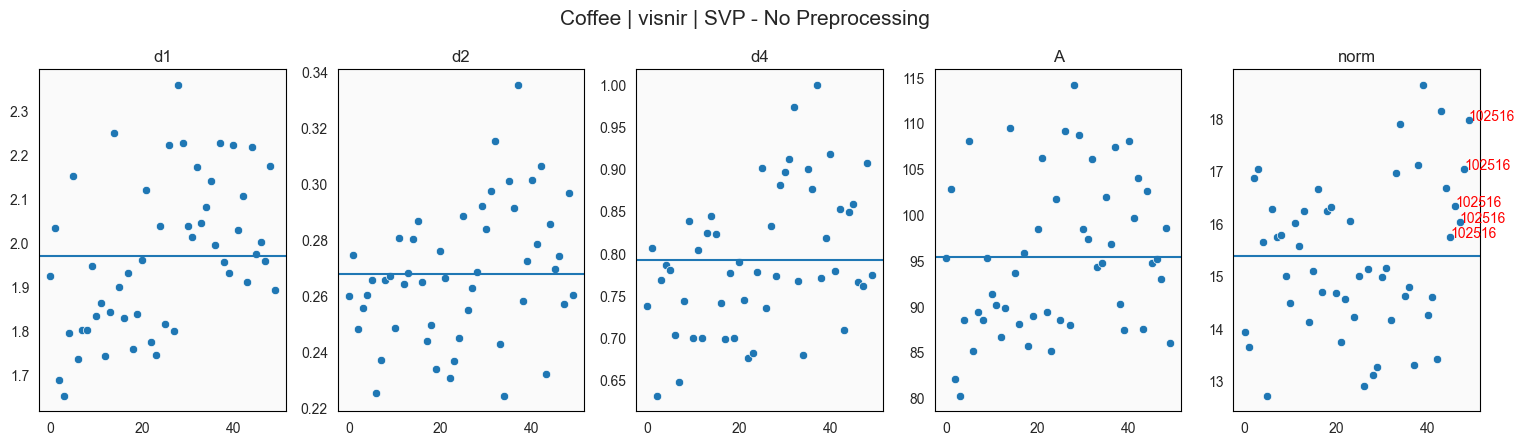

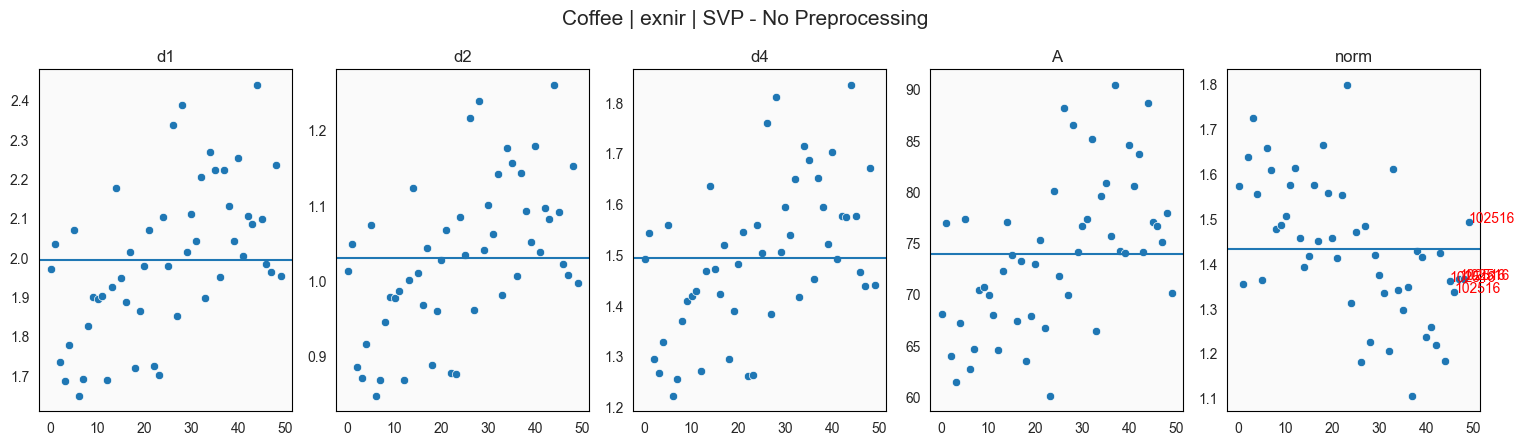

In [78]:
for spectral_range in spectral_ranges:
    SAMPLE_TYPE = f'{label} | {spectral_range}'
    raw_df = spectral_ranges[spectral_range]['spectrum']
    plot_svp(raw_df, title=f'{SAMPLE_TYPE} | SVP - No Preprocessing')

    raw_df_check = pd.DataFrame(raw_df)
    svp_arr = spectral_vector_properties(raw_df_check, True)

    #metrics cutoff
    metrics = {
        0 : 'd1',
        1 : 'd2',
        2 : 'd4',
        3 : 'A',
        4 : 'norm'
    }
    choice = 4
    maxval, minval = cutoff[spectral_range]['maxval'], cutoff[spectral_range]['minval']

    norm_data = svp_arr[metrics[choice]]
    norm_ax = plt.gcf().axes[choice]

    for idx in range(len(norm_data)):
        if norm_data.iloc[idx] < minval or norm_data.iloc[idx] > maxval or norm_data.index[idx] in outliers_idx:  
            norm_ax.text(idx, norm_data.iloc[idx], norm_data.index[idx], 
                        fontsize=10, color='red')

    plt.draw()

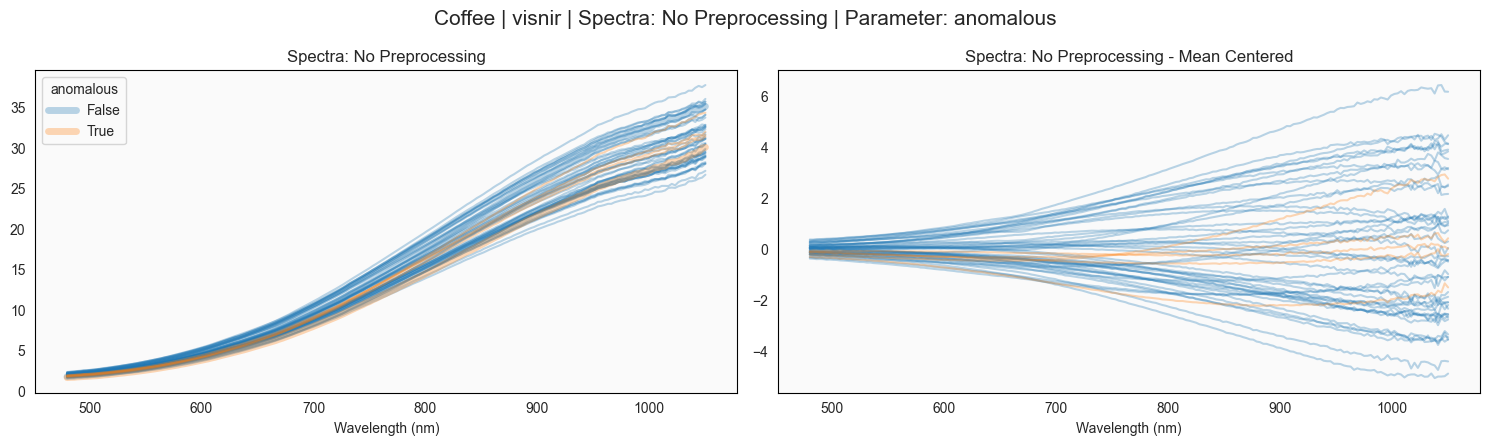

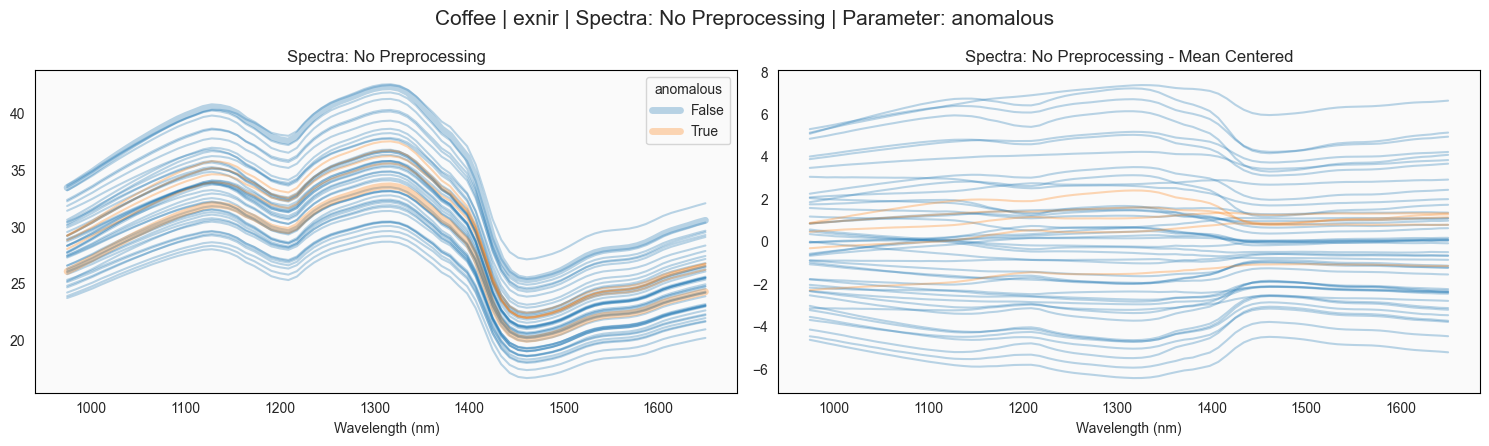

In [79]:
for spectral_range in spectral_ranges:
    SAMPLE_TYPE = f'{label} | {spectral_range}'
    raw_df = spectral_ranges[spectral_range]['spectrum']

    maxval, minval = cutoff[spectral_range]['maxval'], cutoff[spectral_range]['minval']

    raw_df_check = pd.DataFrame(raw_df)
    svp_arr = spectral_vector_properties(raw_df_check, True)

    # anomalous_mask = (svp_arr[metrics[choice]] < minval) | (svp_arr[metrics[choice]] > maxval) | (svp_arr.index.isin(outliers_idx))
    anomalous_mask = (svp_arr.index.isin(outliers_idx))
    # display(anomalous_mask.value_counts())

    spectral_ranges[spectral_range]['anomalous_mask'] = anomalous_mask

    # add a new column in check_df to label anomalous samples
    check_df = raw_df_check.copy(deep=True)
    check_df['anomalous'] = anomalous_mask

    plot_spectra(raw_df_check, labels=check_df[['anomalous']],
                spec_prep=PREPROCESSING,
                sample_type=SAMPLE_TYPE,
                cmap=cmap)
    plt.show()
    plt.close()

In [ ]:
# check which parts of the masks are different
diff_mask = spectral_ranges['visnir']['anomalous_mask'] != spectral_ranges['exnir']['anomalous_mask']
diff_mask.value_counts()

In [ ]:
# create a new mask that is True if either of the masks is True
combined_mask = spectral_ranges['visnir']['anomalous_mask'] | spectral_ranges['exnir']['anomalous_mask']
combined_mask.value_counts()    

## filter outliers

In [ ]:
cleaned_spectra = {}
output_dir = Path(f"../data/processed/")
output_dir.mkdir(exist_ok=True, parents=True)

for spectral_range in spectral_ranges:
    SAMPLE_TYPE = f'{label} | {spectral_range}'
    selected_df = spectral_ranges[spectral_range]['spectrum']

    print(f"Original shape of {spectral_range} data: {selected_df.shape}")
    cleaned_df = selected_df[~combined_mask]
    print(f"Cleaned shape of {spectral_range} data: {cleaned_df.shape}")

    cleaned_df.to_csv(output_dir/f"cleaned_{spectral_range}_input.csv")
    spectral_ranges[spectral_range]['cleaned_spectrum'] = cleaned_df

cleaned_labels = label_df[~combined_mask]
cleaned_labels.to_csv(output_dir/f"cleaned_label.csv")

In [ ]:
for spectral_range in spectral_ranges:
    SAMPLE_TYPE = f'{label} | {spectral_range}'
    raw_df = spectral_ranges[spectral_range]['cleaned_spectrum']

    plot_spectra(raw_df, labels=None,
             spec_prep=PREPROCESSING,
             sample_type=SAMPLE_TYPE,
             cmap=cmap);

In [ ]:
for spectral_range in spectral_ranges:
    SAMPLE_TYPE = f'{label} | {spectral_range}'
    raw_df = spectral_ranges[spectral_range]['cleaned_spectrum']
    plot_svp(raw_df, title=f'{label} | {spectral_range} | SVP - No Preprocessing')